In this process, we will use tensor flow to solve for the housing data regression problem

In [1]:
from sklearn.datasets import fetch_california_housing
import numpy as np
import pandas as pd

housing = fetch_california_housing()

#identify the shape of the dataset
m, n = housing.data.shape

#add a bias term for linear regression
housing_data_plus_bias = np.c_[np.ones((m,1)),housing.data]
n

8

Now we specify the math behind the least-squares regression

In [2]:
import tensorflow as tf
#create tensor flow objects that constrain the matrices used in the data
X = tf.constant(housing_data_plus_bias,dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1,1), dtype=tf.float32, name="y")
XT = tf.transpose(X) #transpose of X, used in the theta formula

#create the theta used for least squares
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT,X)),XT),y)

with tf.Session() as sess:
    theta_value = theta.eval()
print(theta_value)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[[-3.7185181e+01]
 [ 4.3633747e-01]
 [ 9.3952334e-03]
 [-1.0711310e-01]
 [ 6.4479220e-01]
 [-4.0338000e-06]
 [-3.7813708e-03]
 [-4.2348403e-01]
 [-4.3721911e-01]]


Now lets create a stochastic gradient descent process.

In [3]:
tf.reset_default_graph()

#specify the epochs and learning rate
n_epochs = 100
learning_rate = 0.01
batch_size = 20640
n_batches = int(np.ceil(m/batch_size))

#We will want to put the data into a scaled format
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
scaled_housing_data_plus_bias = ss.fit_transform(housing_data_plus_bias)

#now we specify our data X and target y as tensor flow constants
X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32,name="X")
y = tf.constant(housing.target.reshape(-1,1), dtype=tf.float32, name="y")

# now to specify stochastic gradient descent, we must create a set of
# random steps
theta = tf.Variable(tf.random_uniform([n+1,1],-1,1),name="theta")
y_pred = tf.matmul(X,theta, name="predictions")
#now specify the error
error = y_pred - y

#now specify mean squared error
mse = tf.reduce_mean(tf.square(error), name="mse")

#now specify the gradients
#gradients = (2/m)*tf.matmul(tf.transpose(X), error)
#We could also have coded
gradients = tf.gradients(mse,[theta])[0]

#now make for a reassignment of theta after each new iteration
#training_op = tf.assign(theta, theta - learning_rate*gradients)

#OR we could have used (and not even needed a gradients object!)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)


#initialize the variables
init = tf.global_variables_initializer()

#save each mean squared error
mses = []

#create a function that gets a batch of data from the main data set

def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index) 
    indices = np.random.randint(m, size=batch_size) 
    X_batch = scaled_housing_data_plus_bias[indices]
    y_batch = housing.target.reshape(-1, 1)[indices]
    return X_batch, y_batch

#now start the session
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
            best_theta = theta.eval()
            mses.append(mse.eval())
            print('batch index: ',batch_index)
            print("Epoch", epoch, "MSE = ",mse.eval())

print("Minimum error: ",min(mses))

batch index:  0
Epoch 0 MSE =  5.711838
batch index:  0
Epoch 1 MSE =  5.671631
batch index:  0
Epoch 2 MSE =  5.632907
batch index:  0
Epoch 3 MSE =  5.5985513
batch index:  0
Epoch 4 MSE =  5.567606
batch index:  0
Epoch 5 MSE =  5.5365086
batch index:  0
Epoch 6 MSE =  5.5076685
batch index:  0
Epoch 7 MSE =  5.480321
batch index:  0
Epoch 8 MSE =  5.4535875
batch index:  0
Epoch 9 MSE =  5.4304338
batch index:  0
Epoch 10 MSE =  5.406124
batch index:  0
Epoch 11 MSE =  5.3842926
batch index:  0
Epoch 12 MSE =  5.3642025
batch index:  0
Epoch 13 MSE =  5.3445034
batch index:  0
Epoch 14 MSE =  5.3256764
batch index:  0
Epoch 15 MSE =  5.3083878
batch index:  0
Epoch 16 MSE =  5.2918057
batch index:  0
Epoch 17 MSE =  5.276025
batch index:  0
Epoch 18 MSE =  5.2598433
batch index:  0
Epoch 19 MSE =  5.2457333
batch index:  0
Epoch 20 MSE =  5.2317567
batch index:  0
Epoch 21 MSE =  5.2181983
batch index:  0
Epoch 22 MSE =  5.2056866
batch index:  0
Epoch 23 MSE =  5.19282
batch index

Once you have trained your model, you should save it's parameters to disk so you can comeback to it when you want, use it to compare to other models, etc.

You probably want to save checkpoints at regular intervals during training, so that if your computer crashes you can return to that point rather than starting over from scratch.

Tensor flow makes saving and restoring models very easy. We create a saver node at the end of the construction phase (after all variable nodes are created). Then during the execution phase, just call its save method whenever you want to save the model.

In [4]:
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        if epoch%10==0:
            save_path = saver.save(sess,"/tmp/my_model_"+str(epoch)+"_.ckpt")
        
        sess.run(training_op)
    best_theta = theta.eval()
    save_path = saver.save(sess,"/tmp/my_model_final_finished.ckpt")

To restore the model, we just perform the restore method of saver.

In [6]:
with tf.Session() as sess:
    saver.restore(sess, "/tmp/my_model_final_finished.ckpt")

INFO:tensorflow:Restoring parameters from /tmp/my_model_final_finished.ckpt


Ch9 Problem 12: Logistic regression classification problem.

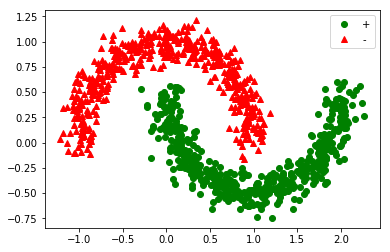

In [3]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
m = 1000
X_moons,y_moons = make_moons(m, noise=0.1, random_state=42)
plt.plot(X_moons[y_moons==1,0],X_moons[y_moons==1,1],'go',label="+")
plt.plot(X_moons[y_moons==0,0],X_moons[y_moons==0,1],'r^',label="-")
plt.legend()
plt.show()

In [4]:
test_ratio = 0.2
test_size = int(m*test_ratio)
X_moons_with_bias = np.c_[np.ones((m,1)),X_moons]
y_moons_column_vector = y_moons.reshape(-1,1)

X_train = X_moons_with_bias[:-test_size]
X_test = X_moons_with_bias[-test_size:]
y_train = y_moons_column_vector[:-test_size]
y_test = y_moons_column_vector[-test_size:]
X_moons_with_bias = np.c_[np.ones((m,1)),X_moons]

In [12]:
import tensorflow as tf
tf.reset_default_graph()

#Now create a place to input the data to when training the model using placeholders
n_inputs = 2
X = tf.placeholder(tf.float32,shape=(None,n_inputs+1),name="X")
y = tf.placeholder(tf.float32,shape=(None,1),name="y")

def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index) 
    indices = np.random.randint(m, size=batch_size) 
    X_batch = scaled_housing_data_plus_bias[indices]
    y_batch = housing.target.reshape(-1, 1)[indices]
    return X_batch, y_batch

#Now we will be using a batched gradient descent to find the minimized error, so create a variable structure theta
#you need a random normal distribution inside theta so these
theta = tf.Variable(tf.random_normal([n_inputs+1,1],-1,1,seed=42),name="theta")

#Now at each instant we want to make a prediction and modify the error
y_lin = tf.matmul(X,theta,name="y_lin")

#Now this process is a logitistic regression. How does logistic regression work? 
# we have a matrix multiplied by a value... then that value is taken exponentially and add 1 to it.
#exp = tf.exp(y_lin,name="exp")
#y_pred = tf.reciprocal(exp+1, name="y_pred")

#we could have also put this into the sigmoid function

y_pred = tf.sigmoid(y_lin,name="sigmoid")

#Now we have to define a log loss.
#then we define a process of putting lowering the error
error = tf.losses.log_loss(y,y_pred)

#Now specify the learning rate
learning_rate = 0.01
#now specify the optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(error)

#Now initialize global variabls
init = tf.global_variables_initializer()

In [15]:
n_epochs = 1000
batch_size = 50
data = X_moons
n_batches = int(np.ceil(data.shape[0]/batch_size))

def random_batch(X_train,y_train, batch_size):
    rnd_indices = np.random.randint(0,len(X_train),batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        for batch in range(batch_size):
            #fetch a batch at each point
            X_batch, y_batch = random_batch(X_train, y_train,batch_size)
            #use the session to run the training optimizer
            sess.run(training_op,feed_dict={X:X_batch,y:y_batch})
        loss_val = error.eval({X:X_test,y:y_test})
        if epoch%100==0:
            print('loss: ',loss_val)

loss:  0.9956636
loss:  0.2895711
loss:  0.27856556
loss:  0.27498057
loss:  0.2735479
loss:  0.27414542
loss:  0.27374113
loss:  0.2741371
loss:  0.27423912
loss:  0.27391765


# Problem in chapter 9:
   * Make a binary classifier using a logistic regression() neural net that can be reused easily.
   * Save checkpoints using a saver at regular intervals during training, and save the final model at the end of training.
   * Restore the last checkpoint upon startup if training was interrupted
   * Define the graph using nice scopes so the graph looks in Tensorboard
   * Add summaries to visualize learning curves in tensor board
   * Try modifying hyperparameters such as learning rate/batch size and look at the shape of the learning curve.

### Modify the data

One technique that might result in better performance is to modify the features and create new ones so that we have polynomial features, such as x**2 and x**3.

In [5]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import tensorflow as tf
m = 1000
X_moons,y_moons = make_moons(m, noise=0.1, random_state=42)
test_ratio = 0.2
test_size = int(m*test_ratio)
X_moons_with_bias = np.c_[np.ones((m,1)),X_moons]
y_moons_column_vector = y_moons.reshape(-1,1)

X_train = X_moons_with_bias[:-test_size]
X_test = X_moons_with_bias[-test_size:]
y_train = y_moons_column_vector[:-test_size]
y_test = y_moons_column_vector[-test_size:]
X_moons_with_bias = np.c_[np.ones((m,1)),X_moons]
X_train_enhanced = np.c_[X_train, X_train[:,1]**2, X_train[:,2]**2, X_train[:,1]**3, X_train[:,2]**3]
X_test_enhanced = np.c_[X_test, X_test[:,1]**2, X_test[:,2]**2, X_test[:,1]**3, X_test[:,2]**3]

tf.reset_default_graph()

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Now make a function that builds the tensor flow graph

In [6]:
def log_reg(X,y,initializer=None, seed=42, learning_rate=0.01):
    n_inputs_including_bias = int(X.get_shape()[1])
    with tf.name_scope("logistic_regression"):
        
        #specify the model
        with tf.name_scope("model"):
            # we specify an intializer to create a bunch of weights to start with
            if initializer is None:
                initializer = tf.random_uniform([n_inputs_including_bias,1],-1,1,seed=seed)
            theta = tf.Variable(initializer,name="theta")
            logits = tf.matmul(X,theta, name="logits")
            y_proba = tf.sigmoid(logits)
        
        #specify the training procedure and loss optimization
        with tf.name_scope("train"):
            loss = tf.losses.log_loss(y,y_proba, scope="loss")
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(loss)
            loss_summary = tf.summary.scalar('log_loss',loss)
        
        #specify the variables initializer
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
        
        #specify a saver functionality
        with tf.name_scope("save"):
            saver = tf.train.Saver()
            
        return y_proba, loss, training_op, loss_summary, init, saver

Now specify the function to get the name of the logging directory used to save the summaries of a tensor board.

In [7]:
from datetime import datetime

def log_directory(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += '-'
    name = prefix + 'run-'+now
    return "{}/{}".format(root_logdir, name)

Now that we have a function to perform our operations, build a graph using tensor flow ops.

In [8]:
#specify inputs and the directory to save model evolution
n_inputs = 6
logdir = log_directory("logreg")

#initalize variables X and y
X = tf.placeholder(tf.float32, shape=(None,n_inputs+1),name="X")
y = tf.placeholder(tf.float32, shape=(None,1), name="y")

y_proba, loss, training_op, loss_summary, init, saver = log_reg(X,y)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

Now we can train the model. Start by checking whether a previousn traing was interrupted, if so load from the checkpoint and continue training from the epoch number we saved.

In [15]:
def random_batch(X_train,y_train, batch_size):
    rnd_indices = np.random.randint(0,len(X_train),batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

import os
#specify the number of epochs, batch size and the number of batches
n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m/batch_size))

#specify the checkpoint paths for saving. One for checkpoints, one for each epoch and one for the final model
checkpoint_path = "/tmp/my_logreg_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_logreg_model"

#this is how we load a model from a training point
with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        #if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            #this is how we save parts of the file
            print("f.read()",f.read())
            #start_epoch = int(f.read())
        print("Training was interrupted, continuing at epoch ", start_epoch)
        saver.restore(sess, checkpoint_path)
    
    else:
        start_epoch = 0
        sess.run(init)
    
    #start training in from the start epoch, whether it be zero or another point
    for epoch in range(start_epoch,n_epochs):
        for batch_index in range(n_batches):
            
            #specify a batch to train with
            X_batch, y_batch = random_batch(X_train_enhanced,y_train,batch_size)
            
            #train by running the training optimizer, feeding the right data
            sess.run(training_op,feed_dict={X:X_batch,y:y_batch})
            
        #evaluate the loss at the end of each epoch, and get a summary string
        loss_val,summary_str = sess.run([loss,loss_summary],feed_dict={X:X_test_enhanced,y:y_test})
        
        #add a summary to the tensor graph
        file_writer.add_summary(summary_str,epoch)
        
        #At every 500 epochs, make an incremental save
        if epoch%500==0:
            print("Epoch:",epoch, "\t Loss:",loss_val)
            saver.save(sess,checkpoint_path)
            
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d"%(epoch+1))
    
    #at the end of the training, save the model
    saver.save(sess, final_model_path)
    
    #evaluate the probability
    y_proba_val = y_proba.eval(feed_dict={X:X_test_enhanced, y:y_test})
    
    os.remove(checkpoint_epoch_path)

f.read() b'15501'
Training was interrupted, continuing at epoch  4501
INFO:tensorflow:Restoring parameters from /tmp/my_logreg_model.ckpt
Epoch: 5000 	 Loss: 0.02971563
Epoch: 5500 	 Loss: 0.029370932
Epoch: 6000 	 Loss: 0.02903011
Epoch: 6500 	 Loss: 0.028709078
Epoch: 7000 	 Loss: 0.02845581
Epoch: 7500 	 Loss: 0.028137662
Epoch: 8000 	 Loss: 0.027918482
Epoch: 8500 	 Loss: 0.027613817
Epoch: 9000 	 Loss: 0.027371831
Epoch: 9500 	 Loss: 0.027152156
Epoch: 10000 	 Loss: 0.026939759


Now we check to see the precision and recall

In [20]:
from sklearn.metrics import precision_score, recall_score
y_pred = (y_proba_val >= 0.5)
print("Precision: ", precision_score(y_pred,y_test))
print("Recall: ",recall_score(y_pred,y_test))

Precision:  0.9797979797979798
Recall:  0.9797979797979798


In [28]:
if os.path.isfile(checkpoint_epoch_path):
        #if the checkpoint file exists, restore the model and load the epoch number
    with open(checkpoint_epoch_path, "rb") as f:
            #this is how we save parts of the file
            print(f.read())
        print("Training was interrupted, continuing at epoch ", start_epoch)
        #saver.restore(sess, checkpoint_path)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 6)

In [24]:
os.path.isfile(checkpoint_epoch_path)

True